In [1]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import imghdr
import numpy as np

C:\Users\ammar\AppData\Local\Temp\ipykernel_17568\1140302781.py:5: DeprecationWarning: imghdr was removed in Python 3.13. Please be aware that you are currently NOT using standard 'imghdr', but instead a separately installed 'standard-imghdr'.
  import imghdr


In [2]:
data_dir = '../data'
#os.listdir(os.path.join('data', 'happy'))

In [3]:
image_exts = ['jpeg', 'png', 'bmp', 'jpg']

In [4]:
#img = cv2.imread(os.path.join(data_dir, 'sad', 'Crying-girl.jpg'))
#plt.imshow(img)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in extension list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
             print("Image not in extension list {}".format(image_path))

In [6]:
# 1. Create a dataset of file paths
#data_dir = 'data'
patterns = [os.path.join(data_dir, f'*/*.{ext}') for ext in image_exts ]
image_paths = tf.data.Dataset.list_files(patterns, shuffle=True)

# Get the total number of images for splitting
num_images = tf.data.experimental.cardinality(image_paths).numpy() #Returns the number of elements (file paths) in the image_paths dataset
print(f"Found {num_images} images.")

# 2. Create a function to load and process each image
class_list = []
for item in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, item)):
        class_list.append(item)
CLASS_NAMES = np.array(class_list)

def process_path(file_path):
    # Get label from the folder name
    label = tf.strings.split(file_path, os.path.sep)[-2] == CLASS_NAMES
    label = tf.argmax(label)

    # Load and decode the image
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3)
    img.set_shape([None, None, 3])

    # Resize and scale the image (scaling is now included here)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0

    return img, label

# 3. Create the main labeled dataset
labeled_data = image_paths.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# 4. Split the data
train_size = int(num_images * 0.7)
val_size = int(num_images * 0.2)
test_size = num_images - train_size - val_size #

train = labeled_data.take(train_size)
val = labeled_data.skip(train_size).take(val_size)
test = labeled_data.skip(train_size + val_size).take(test_size)

# 5. Apply batching and prefetching for performance
BATCH_SIZE = 32 #
train = train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val = val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 166 images.


In [7]:
#data = tf.keras.utils.image_dataset_from_directory('data')

In [8]:
#data_iterator = data.as_numpy_iterator()
#batch = data_iterator.next()
#batch[0].max()

In [9]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

Scaling

In [10]:
#data = data.map(lambda x, y : (x/255, y))

In [11]:
#data_iterator = data.as_numpy_iterator()
#batch = data_iterator.next()

In [12]:
#batch[0].max()

In [13]:
# fig, ax = plt.subplots(ncols=5, figsize=(20,20))
# for idx, img in enumerate(batch[0][:5]):
#     ax[idx].imshow(img)
#     ax[idx].title.set_text(batch[1][idx])

In [14]:
# len(data)

In [15]:
# train_size = int(len(data)*.7)
# val_size = int(len(data)*.2)
# test_size = int(len(data)*.2)

In [16]:
# test_size+train_size+val_size

In [17]:
# train = data.take(train_size)
# val = data.skip(train_size).take(val_size)
# test = data.skip(train_size+val_size).take(test_size)

Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16,(3,3),1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\ammar\PycharmProjects\JupyterProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
hist = model.fit(train, epochs=20, validation_data = val)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.5259 - loss: 1.7975 - val_accuracy: 0.3939 - val_loss: 1.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.5431 - loss: 0.7654 - val_accuracy: 0.5455 - val_loss: 0.7439
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6121 - loss: 0.6326 - val_accuracy: 0.6970 - val_loss: 0.5640
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.6810 - loss: 0.5804 - val_accuracy: 0.7273 - val_loss: 0.4893
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.6638 - loss: 0.6423 - val_accuracy: 0.7273 - val_loss: 0.6406
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.7500 - loss: 0.5902 - val_accuracy: 0.6364 - val_loss: 0.5766
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6638 - loss: 0.5761 - val_accuracy: 0.8485 - val_loss: 0.4731
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.7759 - loss: 0.5031 - val_accuracy: 0.6970 - val_loss:

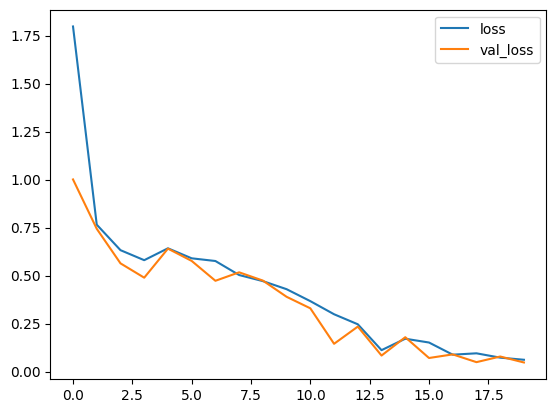

In [24]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

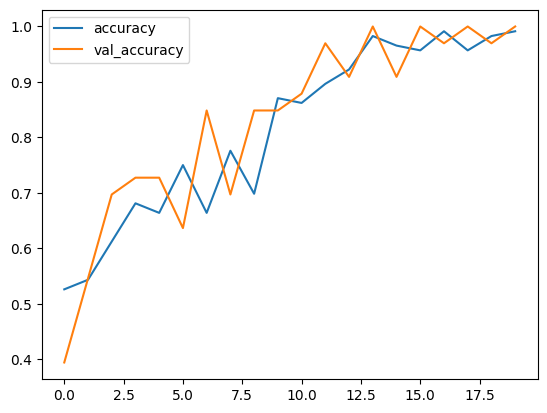

In [25]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [28]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [29]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


In [30]:
img = cv2.imread('img.png')
# plt.imshow(img)
# plt.show()

In [31]:
resize = tf.image.resize(img, (256,256))
# plt.imshow(img)

In [32]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [33]:
# yhat

array([[9.9600911e-01],
       [9.5763415e-01],
       [9.7492886e-01],
       [9.9957293e-01],
       [9.7188646e-01],
       [9.9686736e-01],
       [9.2820573e-04],
       [7.7239096e-02],
       [9.0276903e-01],
       [9.6665043e-01],
       [5.4584213e-02],
       [9.6780431e-01],
       [9.9993497e-01],
       [9.9997401e-01],
       [9.7402984e-01],
       [2.2298032e-05],
       [4.7991212e-04]], dtype=float32)

In [34]:
# if yhat > 0.5:
#     print(f'Predicted class is Sad')
# else:
#     print(f'Predicted class is Happy')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
# yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
